In [5]:
import numpy as np
import cvxpy as cp
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.special import expit, logit
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from contextlib import contextmanager
import multiprocessing as mp
from threading import Thread


In [6]:
# -----------------------------
# Optimistic combinatorial bandit with global budget
# -----------------------------
class OptimisticBandit:
    def __init__(self, products, prices, budget, T):
        self.products = products
        self.prices = prices
        self.budget = budget
        self.T = T
        self.n = defaultdict(int)
        self.sum_r = defaultdict(float)
        self.sum_c = defaultdict(float)

    def conf_width(self, n):
        return np.sqrt((2 * np.log(self.T)) / n) if n>0 else 1.0

    def _conf_width_vec(self, n):
        """Vectorized confidence width. Falls back to per-element if needed."""
        n = np.asarray(n, dtype=float)
        try:
            w = self.conf_width(n)        # if your conf_width already supports arrays
            w = np.asarray(w, dtype=float)
        except Exception:
            w = np.array([self.conf_width(int(ni)) for ni in n], dtype=float)
        return w

    def _ensure_atom_cache(self):
        """Precompute and cache atom indexing for vectorized optimization."""
        if getattr(self, "_atom_cache_ready", False):
            return

        # Flatten all (product, price) atoms
        atoms = [(p, pr) for p in self.products for pr in self.prices[p]]
        self._atoms = atoms
        self._n_atoms = len(atoms)
        # Arrays for products and prices aligned with atom index
        self._atom_products = np.array([p for p, pr in atoms], dtype=object)
        self._atom_prices   = np.array([pr for p, pr in atoms], dtype=float)

        # Indices per product
        self._idxs_by_product = {
            p: np.where(self._atom_products == p)[0] for p in self.products
        }

        self._atom_cache_ready = True

    def play(self, t, rho_t):
        # Build (or reuse) atom index caches
        self._ensure_atom_cache()

        # Pull stats into vectors aligned with atom order
        n     = np.array([self.n[a]     for a in self._atoms], dtype=float)   # (A,)
        sum_r = np.array([self.sum_r[a] for a in self._atoms], dtype=float)   # (A,)
        sum_c = np.array([self.sum_c[a] for a in self._atoms], dtype=float)   # (A,)

        # Means with safe divide (0 if n==0)
        mean_r = np.divide(sum_r, n, out=np.zeros_like(sum_r), where=n > 0)
        mean_c = np.divide(sum_c, n, out=np.zeros_like(sum_c), where=n > 0)

        # Confidence widths (vectorized)
        w = self._conf_width_vec(n)

        # UCB / LCB vectors
        r_ucb = mean_r + w
        c_lcb = np.maximum(0.0, mean_c - w)

        # CVXPY decision variable for all atoms (continuous 0–1)
        x = cp.Variable(self._n_atoms)

        # Objective and constraints (vectorized)
        obj = cp.Maximize(r_ucb @ x)
        constraints = [
            c_lcb @ x <= rho_t,   # budget/resource constraint
            x >= 0,
            x <= 1
        ]
        # Each product: choose at most one price
        for p, idxs in self._idxs_by_product.items():
            if idxs.size:
                constraints.append(cp.sum(x[idxs]) <= 1)

        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.CLARABEL)

        xv = np.asarray(x.value).ravel() if x.value is not None else np.zeros(self._n_atoms)

        # Build action: pick the price with largest x for each product
        action = {}
        for p, idxs in self._idxs_by_product.items():
            if idxs.size == 0:
                continue
            # argmax over the product's slice
            k_rel = int(np.argmax(xv[idxs]))
            k = idxs[k_rel]
            action[p] = float(self._atom_prices[k])

        return action


    def update(self, outcomes, t):
        for (p,pr), (r,c) in outcomes.items():
            self.n[(p,pr)] += 1
            self.sum_r[(p,pr)] += r
            self.sum_c[(p,pr)] += c

In [7]:
class MultiProductPricingEnvironment:
    def __init__(self, products,
                 means,
                 covs,
                 seed=42,
                 plot_distribution=True,
                 T=None):
        self.products = products
        self.d = len(products)
        self.means, self.covs = self.delta_method_latent_from_logitnormal(means, covs)
        self.rng = np.random.default_rng(seed)
        if T is not None:
            self.valuations_samples = self.sample_valuations(T)
            self.cached_valuations = True
            self.i=0
        else:
            self.cached_valuations = False
        if plot_distribution:
            n_samples = 100_000
            bins=100
            samples = self.sample_valuations(n_samples)
            for i, product in enumerate(products):

                plt.figure(figsize=(7, 3))
                plt.hist(samples[:, i], bins=bins, density=True)
                plt.title(f"Distribution of valuations for product {product} (100000 rounds)")
                plt.xlabel("valuation")
                plt.ylabel("density")
                plt.xlim(0, 1)
                plt.tight_layout()
                plt.show()



    @staticmethod
    def delta_method_latent_from_logitnormal(m, C):
        """
        Approximate latent Gaussian parameters (mu, Sigma_Z) for a multivariate logit-normal
        with desired mean vector m in (0,1)^d and covariance C.

        Uses first-order delta method:
            J = diag( m_i * (1 - m_i) )
            Sigma_Z ≈ J^{-1} C J^{-1}
            mu ≈ logit(m)
        """
        m = np.asarray(m, dtype=float)
        C = np.asarray(C, dtype=float)
        if m.ndim != 1:
            raise ValueError("m must be a 1-D array of means in (0,1).")
        if C.shape != (m.size, m.size):
            raise ValueError("C must be a square matrix with same dimension as m.")
        if np.any((m <= 0) | (m >= 1)):
            raise ValueError("All entries of m must lie strictly in (0,1).")

        mu = logit(m)
        gprime = m * (1.0 - m)  # derivative of expit at mu where expit(mu)=m
        if np.any(gprime <= 0):
            raise ValueError("Means too close to 0 or 1 make the delta method unstable.")
        Jinv = np.diag(1.0 / gprime)
        Sigma_Z = Jinv @ C @ Jinv
        # Symmetrize small numerical asymmetry
        Sigma_Z = 0.5 * (Sigma_Z + Sigma_Z.T)
        return mu, Sigma_Z

    def sample_valuations(self, n=1):
        if self.cached_valuations:
            self.i+=1
            return self.cached_valuations[self.i-1]
        z = np.random.multivariate_normal(self.means, self.covs, size=n)
        if n==1:
            return expit(z).ravel()
        return expit(z)

    def round(self, chosen_prices):
        chosen_prices_arr = np.array([chosen_prices[p] for p in self.products], dtype=float)
        vals = self.sample_valuations()
        sold = (vals >= chosen_prices_arr).astype(int)
        reward = float(np.dot(chosen_prices_arr, sold))
        return sold, reward


In [8]:
# -----------------------------
# Oracle (clairvoyant)
# -----------------------------
def oracle_action(products, prices, env, rho_t):
    atoms = [(p,pr) for p in products for pr in prices[p]]
    true_r = {a:0.0 for a in atoms}
    true_c = {a:0.0 for a in atoms}
    vals = env.sample_valuations()
    for i,p in enumerate(products):
        for pr in prices[p]:
            sold = int(vals[i] >= pr)
            true_r[(p,pr)] = sold*pr
            true_c[(p,pr)] = sold

    x = {a: cp.Variable(boolean=False) for a in atoms}
    obj = cp.Maximize(cp.sum([x[a]*true_r[a] for a in atoms]))
    constraints = [cp.sum([x[a]*true_c[a] for a in atoms]) <= rho_t]
    for p in products:
        constraints.append(cp.sum([x[(p,pr)] for pr in prices[p]]) <= 1)
    for a in atoms:
        constraints.append(x[a]>=0)
        constraints.append(x[a]<=1)

    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.CLARABEL)

    action = {}
    expected_reward = 0
    for p in products:
        best_price, best_val = None, -1
        for pr in prices[p]:
            val = x[(p,pr)].value
            if val is not None and val > best_val:
                best_val = val
                best_price = pr
        if best_price is not None:
            action[p] = best_price
            expected_reward += true_r[(p,best_price)]
    return action, expected_reward

### Parallelization helper functions

In [ ]:

def _progress_listener(q, n_trials, leave=False):
    """
    Render one tqdm bar per trial in the main process.
    Workers send ('init', trial_idx, total), ('update', trial_idx, n), ('close', trial_idx, 0).
    """
    bars = {}
    closed = set()
    while len(closed) < n_trials:
        msg = q.get()
        if msg is None:  # termination signal
            break
        kind, trial_idx, val = msg
        if kind == 'init':
            # Create the bar for this trial if not exists
            if trial_idx not in bars:
                bars[trial_idx] = tqdm(total=int(val),
                                       desc=f"Trial {trial_idx+1}",
                                       position=trial_idx,
                                       leave=leave)
        elif kind == 'update':
            if trial_idx in bars:
                bars[trial_idx].update(int(val))
        elif kind == 'close':
            if trial_idx in bars and trial_idx not in closed:
                bars[trial_idx].close()
                closed.add(trial_idx)

    # Ensure all bars are closed
    for tid, bar in bars.items():
        if tid not in closed:
            bar.close()

def _start_progress(n_trials, leave=False):
    mgr = mp.Manager()
    q = mgr.Queue()
    th = Thread(target=_progress_listener, args=(q, n_trials, leave), daemon=True)
    th.start()
    return q, th, mgr

# ----------------------------------------
# One trial (runs in a worker process)

def run_all_trials_parallel(seeds, products, prices, budget, T, means, covs, n_jobs=-1, leave=False):
    progress_q, progress_thread, mgr = _start_progress(n_trials, leave=leave)
    try:
        results = Parallel(n_jobs=n_jobs, prefer="processes")(
            delayed(run_single_trial)(
                trial_idx, products, prices, budget, T, means, covs, seed, progress_q
            )
            for trial_idx, seed in enumerate(seeds)
        )
    finally:
        # tell listener to exit if not already
        progress_q.put(None)
        progress_thread.join()
        mgr.shutdown()

    return results

# Experiments

Discretizing prices with 17 values


Trial 1:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 5:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 2:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 4:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 6:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 3:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 7:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 8:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 9:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 10:   0%|          | 0/6000 [00:00<?, ?it/s]

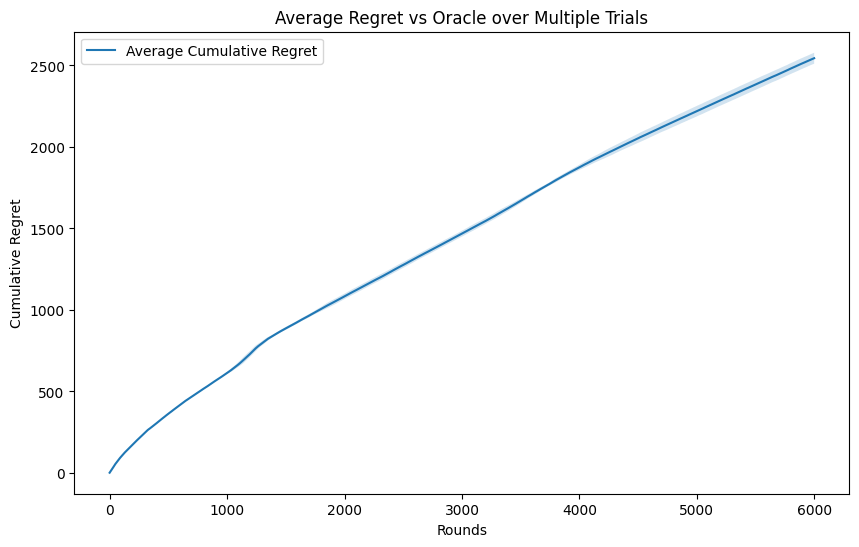

In [9]:
products = ['A','B','C']
budget = 12000
T = 6000
n_trials = 10

epsilon = T ** (-0.33)
K = int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
prices = {'A': prices_per_product, 'B': prices_per_product, 'C': prices_per_product}
means = np.array([0.1, 0.5, 0.8])
covs = 0.001*np.array([[5., 1., 2.],
                         [1., 2., 0.8],
                         [2., 0.8, 3.]])

def run_single_trial(trial_idx, products, prices, budget, T, means, covs, seed=None, progress_q=None):
    rng = np.random.default_rng(seed)

    if progress_q is not None:
        progress_q.put(('init', trial_idx, T))

    env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=False)
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0.0

    for t in range(1, T + 1):
        if env.remaining_budget <= 0:
            # close early if budget exhausted
            if progress_q is not None:
                progress_q.put(('close', trial_idx, 0))
            break

        rho_t = env.remaining_budget / (T - t + 1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)

        outcomes = {(p, action[p]): (reward if sold[i] > 0 else 0, sold[i]) for i, p in enumerate(products)}
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

        if progress_q is not None:
            progress_q.put(('update', trial_idx, 1))

    else:
        # loop ended normally
        if progress_q is not None:
            progress_q.put(('close', trial_idx, 0))

    return cumulative_regret


seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,123564]
all_regrets = run_all_trials_parallel(seeds, products, prices, budget, T, means, covs, n_jobs=-1)


# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

Discretizing prices with 17 values


Trial 1:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 2:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 3:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 4:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 5:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 6:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 7:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 8:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 9:   0%|          | 0/6000 [00:00<?, ?it/s]

Trial 10:   0%|          | 0/6000 [00:00<?, ?it/s]

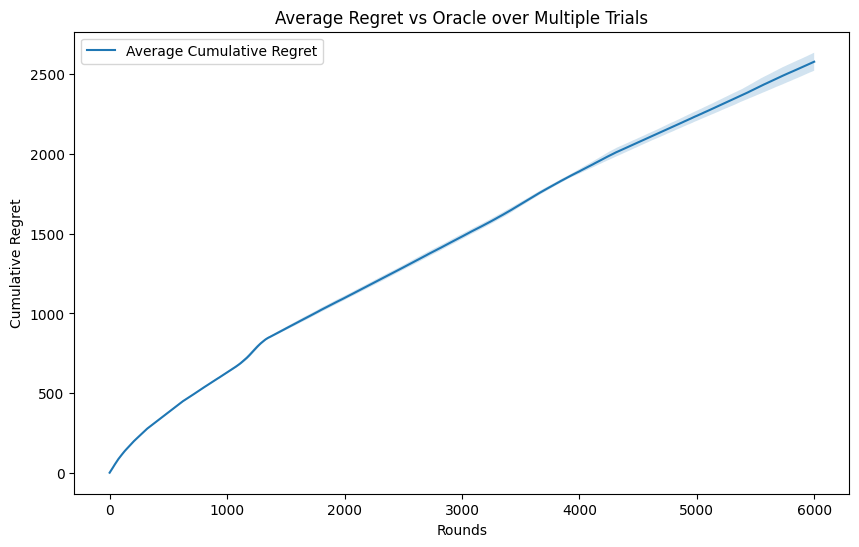

In [10]:
products = ['A','B','C']
budget = 18000
T = 6000
n_trials = 10

epsilon = T ** (-0.33)
K = int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
prices = {'A': prices_per_product, 'B': prices_per_product, 'C': prices_per_product}
means = np.array([0.1, 0.5, 0.8])
covs = 0.001*np.array([[5., 1., 2.],
                         [1., 2., 0.8],
                         [2., 0.8, 3.]])


def run_single_trial(trial_idx, products, prices, budget, T, means, covs, seed=None, progress_q=None):
    rng = np.random.default_rng(seed)

    # Init the per-trial bar
    if progress_q is not None:
        progress_q.put(('init', trial_idx, T))

    env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=False)
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0.0

    for t in range(1, T + 1):
        if env.remaining_budget <= 0:
            # close early if budget exhausted
            if progress_q is not None:
                progress_q.put(('close', trial_idx, 0))
            break

        rho_t = env.remaining_budget / (T - t + 1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)

        outcomes = {(p, action[p]): (reward if sold[i] > 0 else 0, sold[i]) for i, p in enumerate(products)}
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

        if progress_q is not None:
            progress_q.put(('update', trial_idx, 1))

    else:
        # loop ended normally
        if progress_q is not None:
            progress_q.put(('close', trial_idx, 0))

    return cumulative_regret



seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,123564]
all_regrets = run_all_trials_parallel(seeds, products, prices, budget, T, means, covs, n_jobs=-1)


all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

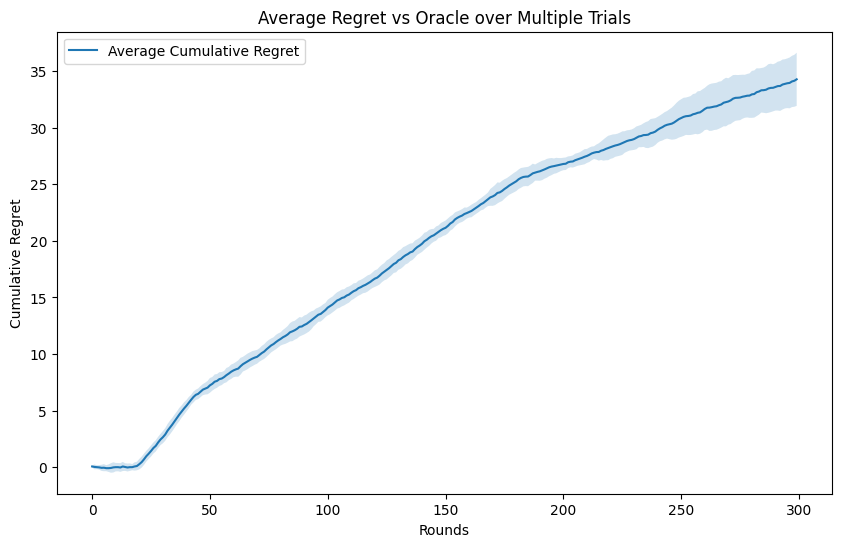

In [5]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 80
T = 300
n_trials = 10

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices, joint_type='dirichlet', dirichlet_alpha=[2,3,4])
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


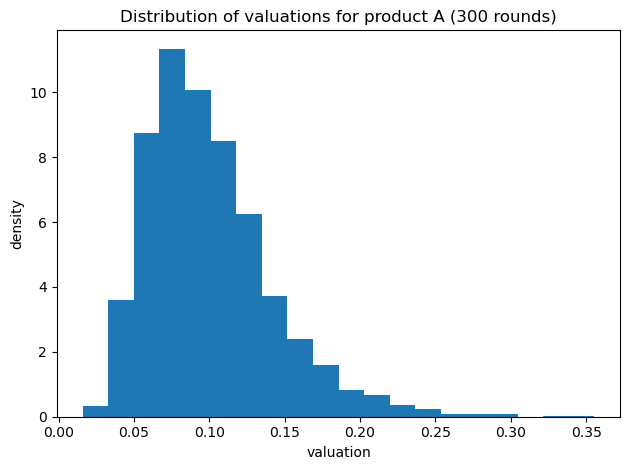

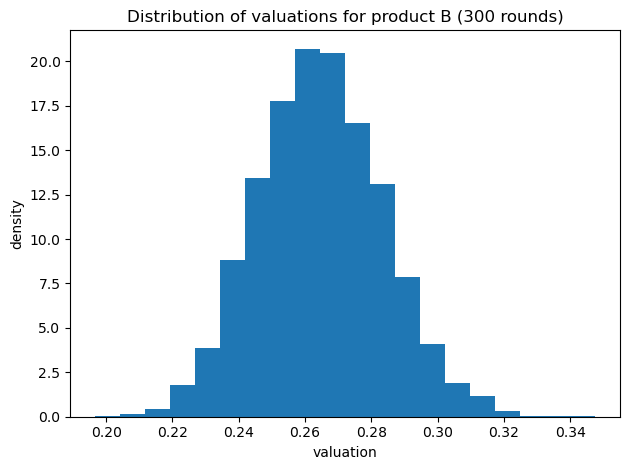

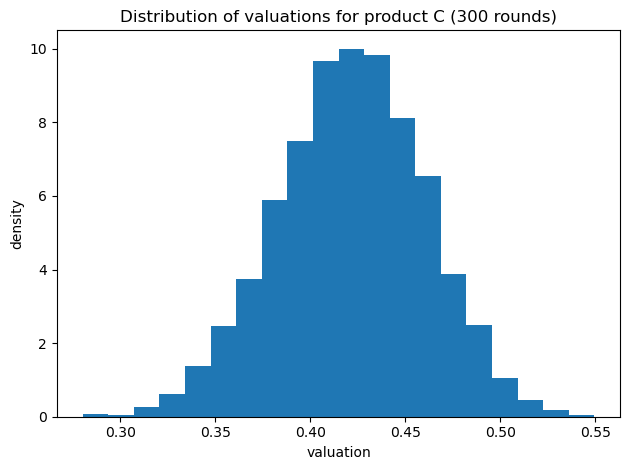

In [38]:
# Let's implement the provided environment, simulate 300 rounds,
# collect the `vals` from each round, and plot their distributions.
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd


# --- Assumed products & prices (you can replace with your own) ---
products = ["A", "B", "C"]
prices = {"A": 0.3, "B": 0.5, "C": 0.7}



# Create the environment with the requested config
np.random.seed(42)
env = MultiProductPricingEnvironment(
    products=products,
    joint_type='correlated_beta',
    copula_param=0.7,
    means = np.array([0.1, 0.5, 0.8]),
    covs = 0.001*np.array([[5., 1., 2.],
                         [1., 2., 0.8],
                         [2., 0.8, 3.]])# used for covariance in latent normal
)


# Simulate 300 rounds and collect vals
vals_records = []
for i in range(6000):
    if i%500==0:
        print(i)
    # we don't actually need sold/reward here; we want the `vals`
    v = env.sample_valuations()
    vals_records.append(v)

vals_array = np.vstack(vals_records)
vals_df = pd.DataFrame(vals_array, columns=products)

# Show the data table to the user to inspect if desired

# Plot a separate histogram for each product
for p in products:

    plt.figure()
    plt.hist(vals_df[p], bins=20, density=True)
    plt.title(f"Distribution of valuations for product {p} (300 rounds)")
    plt.xlabel("valuation")
    plt.ylabel("density")
    plt.tight_layout()
    plt.show()


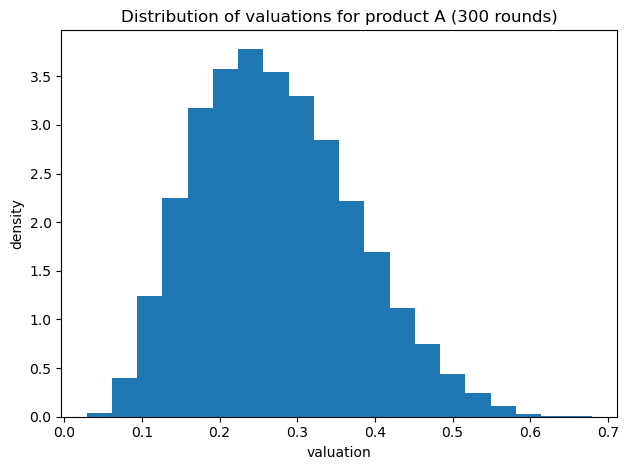

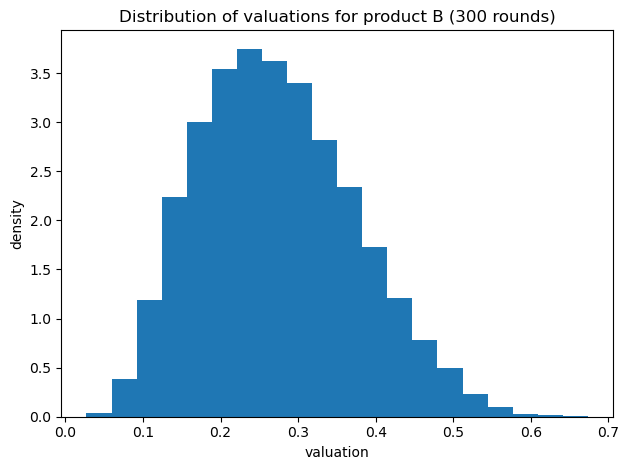

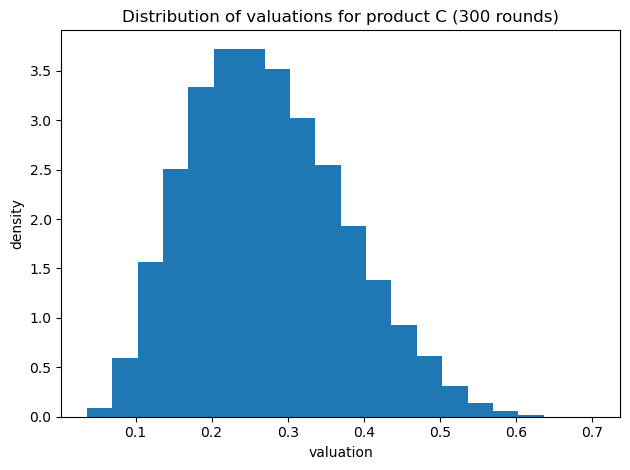

In [11]:
vals_array = np.vstack(vals_records)
vals_df = pd.DataFrame(vals_array, columns=products)

# Show the data table to the user to inspect if desired

# Plot a separate histogram for each product
for p in products:
    plt.figure()
    plt.hist(vals_df[p], bins=20, density=True)
    plt.title(f"Distribution of valuations for product {p} (300 rounds)")
    plt.xlabel("valuation")
    plt.ylabel("density")
    plt.tight_layout()
    plt.show()

In [7]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 3000
T = 30000
n_trials = 2

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices, joint_type='dirichlet', dirichlet_alpha=[2,3,4])
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if t%100==0:
            print(t)
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

KeyboardInterrupt: 

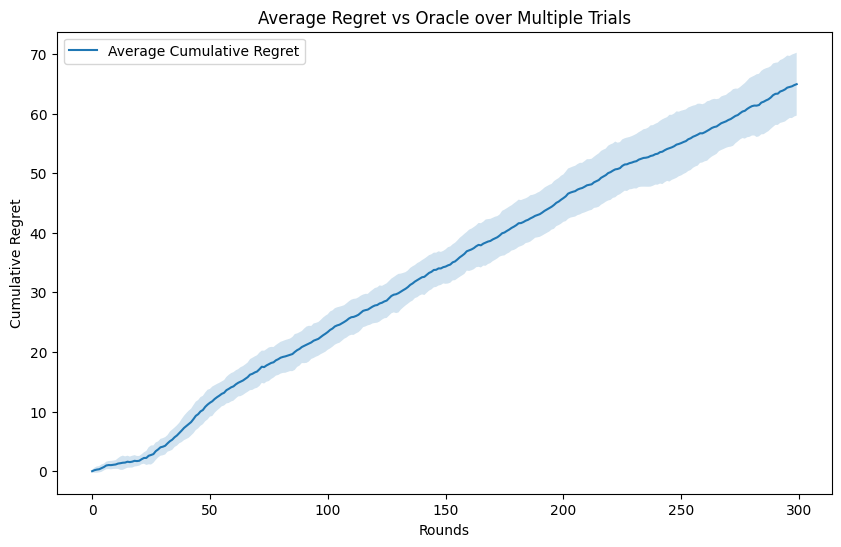

In [6]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 80
T = 300
n_trials = 10

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices, joint_type='multivariate_uniform')
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

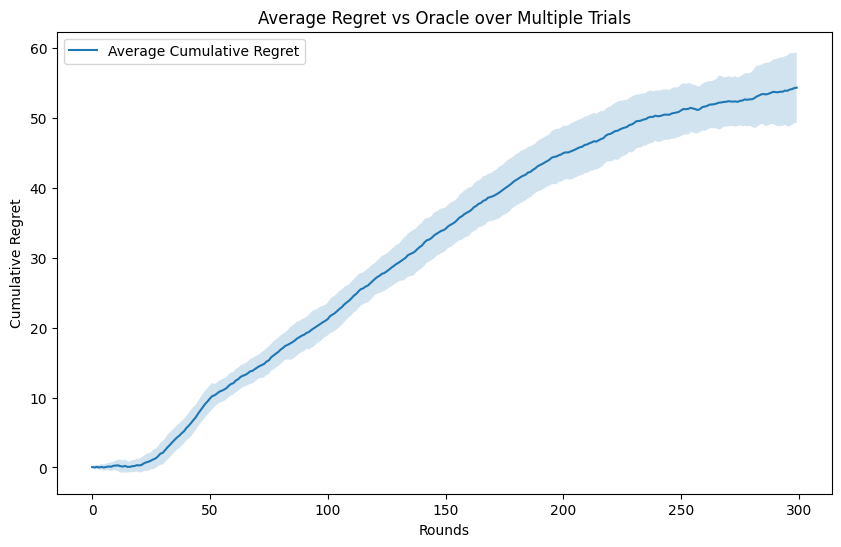

In [7]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 80
T = 300
n_trials = 10

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices, joint_type='correlated_beta',copula_param=0.7)
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

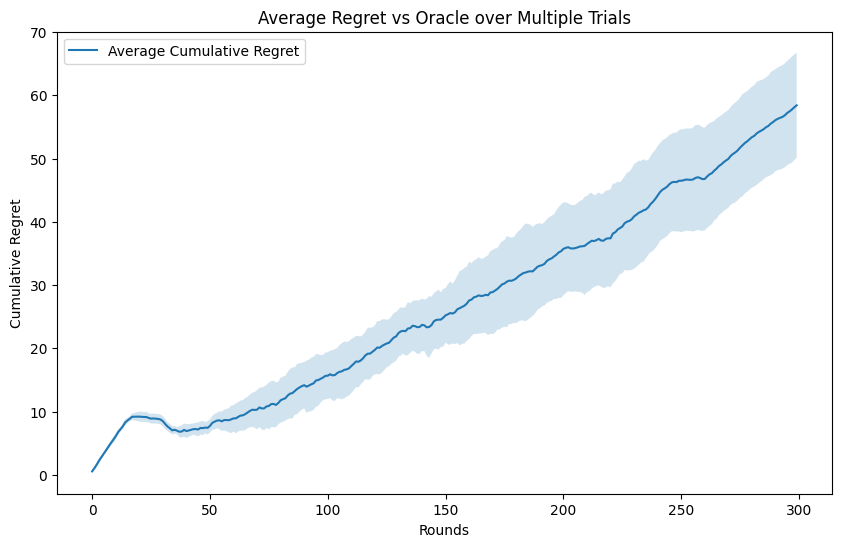

In [9]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 80
T = 300
n_trials = 10

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices, copula_type='gumbel',
    copula_param=2.0,
    marginal_type='beta',
    a=5, b=2)
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

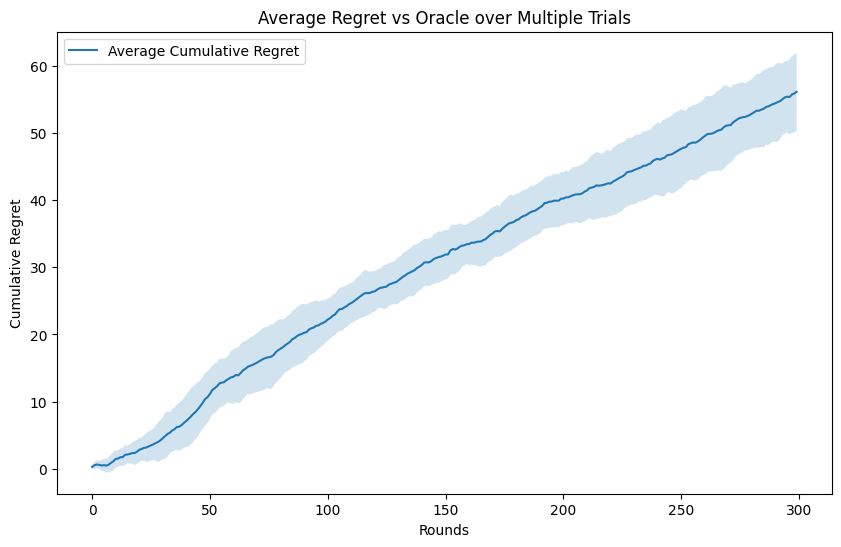

In [10]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 80
T = 300
n_trials = 10

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices,
    copula_type='clayton',
    copula_param=2.0,
    marginal_type='beta',
    a=2, b=5)
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

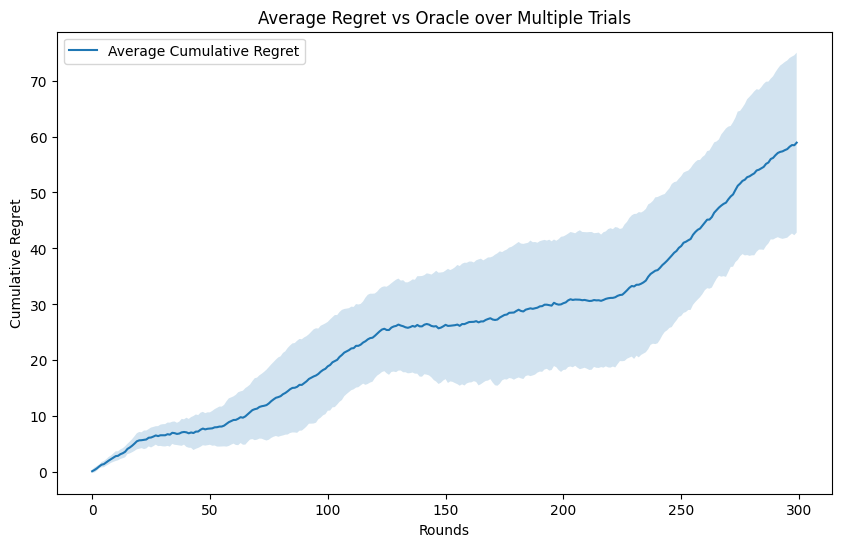

In [11]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 80
T = 300
n_trials = 10

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices,
    copula_type='t',
    copula_param=0.7,
    marginal_type='beta',
    a=2, b=2)
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()